# Implied Volatility Prediction with LSTM

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_palette('husl')

## 1. Data Loading and Exploration

Train data shape: (178340, 97)
Test data shape: (12065, 96)
Sample submission shape: (12065, 53)


,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063


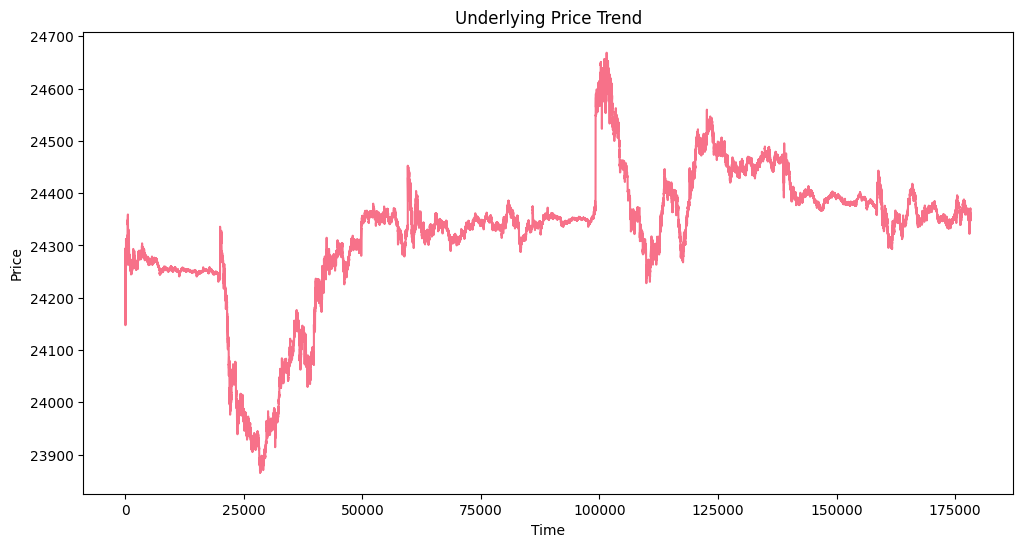

In [7]:
# Load data
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

# Display data shapes
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

# Show first few rows of train data
display(train.head())

# Plot underlying price trend
plt.figure(figsize=(12, 6))
train['underlying'].plot(title='Underlying Price Trend')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

## 2. Feature Engineering

In [ ]:
# Get IV columns from sample submission (excluding timestamp)
sample_iv_cols = [col for col in sample_sub.columns if col != 'timestamp']

# Get IV columns that exist in both train and test data
iv_columns = [col for col in sample_iv_cols 
              if col in train.columns and col in test.columns]

print(f"Number of IV columns in sample submission: {len(sample_iv_cols)}")
print(f"Number of IV columns in both train and test: {len(iv_columns)}")

# Create strike dictionary
strike_dict = {}
for col in iv_columns:
    strike = col.split('_')[-1]
    if strike not in strike_dict:
        strike_dict[strike] = {'call': None, 'put': None}
    
    if col.startswith('call_iv_'):
        strike_dict[strike]['call'] = col
    else:
        strike_dict[strike]['put'] = col

# Display strike dictionary
print("\nStrike dictionary sample:")
print(dict(list(strike_dict.items())[:3]))

Number of IV columns: 52
Strike dictionary sample:
{'24000': {'call': 'call_iv_24000', 'put': 'put_iv_24000'}, '24100': {'call': 'call_iv_24100', 'put': 'put_iv_24100'}, '24200': {'call': 'call_iv_24200', 'put': 'put_iv_24200'}}


## 3. LSTM Model Definition

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # LSTM layers
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        
        # Batch normalization and dropout
        lstm_out = self.bn1(lstm_out)
        lstm_out = self.dropout1(lstm_out)
        
        # Fully connected layers
        x = self.fc1(lstm_out)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

# Print model architecture
sample_model = LSTMModel(input_size=10)
print(sample_model)

LSTMModel(
  (lstm): LSTM(10, 128, num_layers=2, batch_first=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 4. Data Processing Pipeline

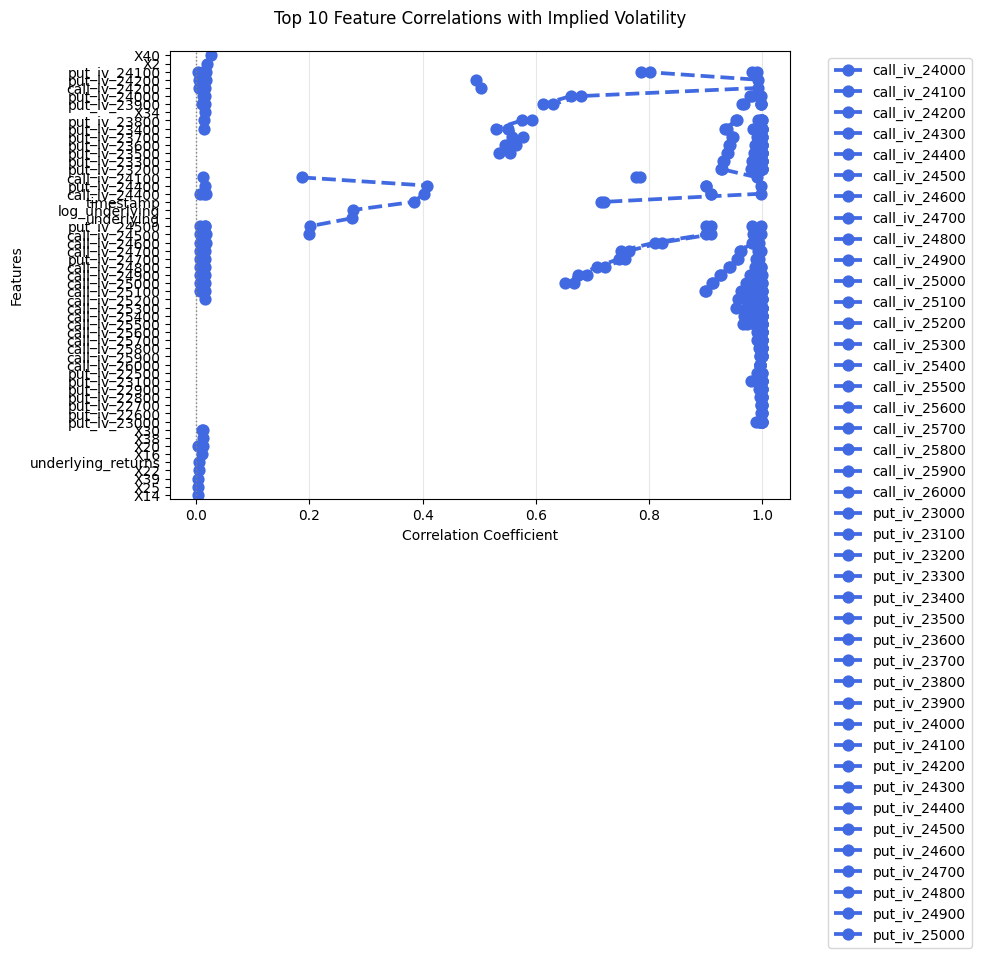

In [19]:
def create_sequence_features(df, sequence_length=10):
    """Create sequence features for LSTM"""
    features = df.copy()
    
    # Basic features
    features['log_underlying'] = np.log(features['underlying'])
    features['underlying_returns'] = features['underlying'].pct_change()
    features['underlying_volatility'] = features['underlying_returns'].rolling(window=20).std()
    
    # Technical indicators
    windows = [5, 10, 20]
    for window in windows:
        features[f'underlying_ma_{window}'] = features['underlying'].rolling(window=window).mean()
        features[f'underlying_std_{window}'] = features['underlying'].rolling(window=window).std()
        features[f'underlying_skew_{window}'] = features['underlying_returns'].rolling(window=window).skew()
        features[f'underlying_kurt_{window}'] = features['underlying_returns'].rolling(window=window).kurt()
    
    # Filter IV columns to only include those that exist in the data
    available_iv_cols = [col for col in iv_columns if col in features.columns]
    if not available_iv_cols:
        raise ValueError("No IV columns found in the data")
    
    # Moneyness features for available strikes
    available_strikes = set(col.split('_')[-1] for col in available_iv_cols)
    for strike in available_strikes:
        strike_price = float(strike)
        features[f'moneyness_{strike}'] = features['underlying'] / strike_price
        features[f'log_moneyness_{strike}'] = np.log(features['underlying'] / strike_price)
    
    # Create sequences
    feature_cols = [col for col in features.columns if col not in ['timestamp'] + available_iv_cols]
    sequences = []
    targets = []
    
    for i in range(len(features) - sequence_length):
        sequence = features[feature_cols].iloc[i:i+sequence_length].values
        target = features[available_iv_cols].iloc[i+sequence_length].values
        sequences.append(sequence)
        targets.append(target)
    
    return np.array(sequences), np.array(targets), feature_cols

# Visualize feature correlation
sample_features = train.iloc[:1000].copy()
sample_features['log_underlying'] = np.log(sample_features['underlying'])
sample_features['underlying_returns'] = sample_features['underlying'].pct_change()

# Select only numeric columns for correlation
numeric_cols = sample_features.select_dtypes(include=[np.number]).columns

def plot_feature_correlations(df, iv_columns, top_n=10):
    """Plot feature correlations using point graph with curves"""
    # Create basic features
    features = df.copy()
    features['log_underlying'] = np.log(features['underlying'])
    features['underlying_returns'] = features['underlying'].pct_change()
    
    # Calculate correlations
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    corr = features[numeric_cols].corr()
    
    # Prepare plot
    plt.figure(figsize=(10, 8))
    
    # Get top features for each IV column
    for iv_col in iv_columns:
        if iv_col in corr.columns:
            # Sort by absolute correlation and take top_n
            top_features = corr[iv_col].abs().sort_values(ascending=False).head(top_n + 1)
            top_features = top_features.drop(iv_col, errors='ignore')  # Remove self-correlation
            
            # Create point plot with connecting lines
            sns.pointplot(x=top_features.values, 
                          y=top_features.index, 
                          join=True, 
                          color='royalblue',
                          markers='o',
                          linestyles='--',
                          label=iv_col)
    
    # Style the plot
    plt.axvline(x=0, color='gray', linestyle=':', linewidth=1)
    plt.title(f'Top {top_n} Feature Correlations with Implied Volatility', pad=20)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
plot_feature_correlations(train, iv_columns)

## 5. Model Training

In [20]:
def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    """Train the model with early stopping"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
        
        # Store losses
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
    return model

## 6. Prediction Pipeline

In [21]:
def predict_iv(data):
    data = data.copy()
    
    # Phase 1: Put-call parity
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            call_mask = data[call_col].isna() & data[put_col].notna()
            data.loc[call_mask, call_col] = data.loc[call_mask, put_col]
            
            put_mask = data[put_col].isna() & data[call_col].notna()
            data.loc[put_mask, put_col] = data.loc[put_mask, call_col]
    
    # Phase 2: LSTM prediction
    X, y, feature_cols = create_sequence_features(data)
    
    # Scale features
    scaler = StandardScaler()
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(X.shape)
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.FloatTensor(y)
    
    # Create data loaders
    train_size = int(0.8 * len(X_tensor))
    train_dataset = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
    val_dataset = TensorDataset(X_tensor[train_size:], y_tensor[train_size:])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    # Create and train model
    model = LSTMModel(input_size=X.shape[2], output_size=len(iv_columns))
    model = train_model(model, train_loader, val_loader)
    
    # Phase 3: Make predictions
    pred_sequences = []
    for i in range(len(data) - 10):
        sequence = data[feature_cols].iloc[i:i+10].values
        pred_sequences.append(sequence)
    
    if pred_sequences:
        pred_sequences = np.array(pred_sequences)
        pred_sequences_reshaped = pred_sequences.reshape(-1, pred_sequences.shape[-1])
        pred_sequences_scaled = scaler.transform(pred_sequences_reshaped)
        pred_sequences_scaled = pred_sequences_scaled.reshape(pred_sequences.shape)
        
        # Convert to PyTorch tensor
        pred_tensor = torch.FloatTensor(pred_sequences_scaled)
        
        # Make predictions
        model.eval()
        with torch.no_grad():
            predictions = model(pred_tensor).numpy()
        
        # Apply predictions
        for i, pred in enumerate(predictions):
            idx = i + 10  # Offset by sequence length
            for j, col in enumerate(iv_columns):
                if col in data.columns and pd.isna(data.at[idx, col]):
                    data.at[idx, col] = pred[j]
    
    # Phase 4: Smoothing and consistency
    for idx, row in data.iterrows():
        for strike, cols in strike_dict.items():
            call_col = cols['call']
            put_col = cols['put']
            
            if call_col in data.columns and put_col in data.columns:
                # Calculate average of call and put IVs
                avg_iv = (data.at[idx, call_col] + data.at[idx, put_col]) / 2
                
                # Apply smoothing
                data.at[idx, call_col] = 0.9 * data.at[idx, call_col] + 0.1 * avg_iv
                data.at[idx, put_col] = 0.9 * data.at[idx, put_col] + 0.1 * avg_iv
    
    # Ensure all values are within reasonable bounds
    for col in iv_columns:
        if col in data.columns:
            data[col] = np.clip(data[col], 0.01, 1.0)
    
    return data

## 7. Validation and Submission

In [22]:
# Create validation split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train split shape: {train_df.shape}")
print(f"Validation split shape: {val_df.shape}")

# Apply to validation set
val_pred = predict_iv(val_df)

# Calculate MSE only on originally masked validation points
mse_vals = []
for col in iv_columns:
    if col in val_df.columns and col in val_pred.columns:
        # Focus only on points that were originally missing
        mask = val_df[col].isna() & val_pred[col].notna()
        if mask.any():
            se = (val_df.loc[mask, col] - val_pred.loc[mask, col]) ** 2
            mse_vals.append(se.mean())

validation_mse = np.mean(mse_vals) if mse_vals else 0
print(f"Validation MSE (masked points only): {validation_mse:.12f}")

# Plot sample predictions vs actuals
sample_col = iv_columns[0]
plt.figure(figsize=(12, 6))
plt.plot(val_df[sample_col], label='Actual')
plt.plot(val_pred[sample_col], label='Predicted', alpha=0.7)
plt.title(f'Validation Results for {sample_col}')
plt.legend()
plt.show()

# Apply to test set
test_pred = predict_iv(test)

# Prepare submission
submission = test_pred[['timestamp'] + iv_columns].copy()
submission.columns = sample_sub.columns

# Verify no missing values
assert submission.isna().sum().sum() == 0, "Missing values detected"
submission.to_csv('submission.csv', index=False)

# Display final results
print("\nFinal Submission Preview:")
display(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Validation MSE: {validation_mse:.12f}")

Train split shape: (142672, 97)
Validation split shape: (35668, 97)


MemoryError: Unable to allocate 14.4 MiB for an array with shape (53, 35668) and data type float64